# Traffic Flow Simulator

In [1]:
from utils import Agent, Road, read_config, Trpf
from itertools import repeat, compress
from altair import Chart
import numpy as np
import pandas as pd

## Functions

In [2]:
def get_route_choices(agents, route_count):
    choices = np.array(list(map(lambda agent: agent.choose_route(), agents)))
    
    route_traveller_counts = {i[0]: np.zeros(len(i[1])) for i in routes.items()}
    for trip, route in choices:
        route_traveller_counts[trip][route] += 1
    #route_traveller_counts = np.bincount(choices[0,:], minlength = route_count)[:, np.newaxis]
    
    return choices, route_traveller_counts

def get_route_costs(roads, choices, route_traveller_counts):
    road_traveller_counts = {i[0]: np.dot(j[1], i[1]) \
        for i, j in zip(route_traveller_counts.items(), route_to_road.items())}
    #list(map(lambda count, road: road.add_travellers(count), road_traveller_counts[:,0], roads))
    #road_costs = np.array(list(map(lambda road: road.report_cost(), roads)))[:, np.newaxis]
    #route_costs = np.array(road_to_route * road_costs)
    return road_traveller_counts

def give_costs(agents, route_costs):    
    list(map(lambda agent, route_costs: agent.recieve_travel_cost(route_costs), agents, repeat(route_costs)))
    
def get_reports(trpf_agents, trpf, choices, excess_traveller_counts):
    reports = list(map(lambda agent, excess: agent.report_congestion(excess),\
        trpf_agents, repeat(excess_traveller_counts)))
    list(map(lambda report: trpf.recieve_report(*report), reports))
    
def give_trpfs(trpf_agents, route_trpfs):
    list(map(lambda agent, trpf: agent.recieve_trpf(trpf), trpf_agents, repeat(route_trpfs)))

## Read the configuration

In [3]:
simulation_folder = '/home/ihsan/Research/TrafficFlowSimulator/simulations/OWNet/'
traffic_file = simulation_folder + 'traffic.properties'
roadnet_file = simulation_folder + 'roadnet.csv'

config = read_config(traffic_file, roadnet_file)

tresholds = config['tresholds']
weights = config['weights']
trpf_use_percent = config['trpf_use_percent']
t = config['t']
agent_counts = config['agent_counts']
change_percent = 0.05 #config['change_percent']
routes = config['routes']
route_opts = config['route_opts']
round_count = config['round_count']
road_params = config['road_params']

print('Tresholds: {}'.format(tresholds))
print('Weights: {}'.format(weights))
print('Trpf Use Percent: {}'.format(trpf_use_percent))
print('T: {}'.format(t))
print('Agent Counts by Trip: {}'.format(agent_counts))
print('Change Percent: {}'.format(change_percent))
print('Route Optimums by Trip: {}'.format(route_opts))
print('Round Count: {}'.format(round_count))
print('Tresholds: {}'.format(routes)) # Trips are 0:AL, 1:AM, 2:BL, 3BM

Tresholds: [10, 20, 50]
Weights: [3, 5, 7]
Trpf Use Percent: 1.0
T: 3
Agent Counts by Trip: [600, 400, 300, 400]
Change Percent: 0.05
Route Optimums by Trip: {0: [0, 109, 376, 0, 0, 0, 145, 0], 1: [0, 0, 0, 154, 25, 154, 0, 0], 2: [0, 41, 0, 0, 0, 0, 0, 0], 3: [340, 84, 0, 0, 0, 0, 0, 272]}
Round Count: 100
Tresholds: {0: [['A', 'C', 'G', 'J', 'I', 'L'], ['A', 'C', 'G', 'J', 'L'], ['A', 'C', 'F', 'I', 'L'], ['A', 'C', 'D', 'G', 'J', 'I', 'L'], ['A', 'C', 'D', 'G', 'J', 'L'], ['A', 'D', 'G', 'J', 'I', 'L'], ['A', 'D', 'G', 'J', 'L'], ['A', 'C', 'G', 'F', 'I', 'L']], 1: [['A', 'C', 'D', 'H', 'K', 'M'], ['A', 'C', 'G', 'J', 'K', 'M'], ['A', 'C', 'G', 'H', 'K', 'M'], ['A', 'D', 'H', 'K', 'M'], ['A', 'C', 'G', 'J', 'M'], ['A', 'C', 'G', 'K', 'M'], ['A', 'B', 'E', 'H', 'K', 'M'], ['A', 'C', 'D', 'E', 'H', 'K', 'M']], 2: [['B', 'D', 'G', 'J', 'I', 'L'], ['B', 'D', 'G', 'J', 'L'], ['B', 'A', 'C', 'G', 'J', 'I', 'L'], ['B', 'A', 'C', 'G', 'J', 'L'], ['B', 'A', 'C', 'F', 'I', 'L'], ['B', 'E', 'D

## Initialize the simulation

In [4]:
trips = np.hstack([np.ones(agent_counts[i])*i for i in range(len(agent_counts))])

roads = []
road_inds = {}
for i, params in enumerate(road_params.itertuples(index=False)):
    road = Road(*params)
    roads.append(road)
    road_name = params[0] + params[1] # Node 1 + Node 2
    road_inds[road_name] = i

route_to_road = {i[0] : np.zeros((len(roads), len(i[1]))) for i in routes.items()}
for trip, trip_routes in routes.items():
    for i, route in enumerate(trip_routes):
        #print(routes)
        for e in range(1, len(route)):
            try:
                road_name = route[e-1] + route[e]
                j = road_inds[road_name]
            except KeyError:
                road_name = route[e] + route[e-1]
                j = road_inds[road_name]
                
            route_to_road[trip][j, i] = 1

road_to_route = {i[0]: i[1].T for i in route_to_road.items()}
route_counts = {i[0]: len(i[1]) for i in road_to_route.items()}

routes = {i[0]: np.arange(len(i[1])) for i in routes.items()}
agents = []
trpf_agents = []
for tag, trip in zip(range(sum(agent_counts)), trips):
    agent = Agent(tag, tresholds, weights, trip, routes, change_percent, trpf_use_percent)
    agents.append(agent)
    if agent.uses_trpf():
        trpf_agents.append(agent)
        
trpf = Trpf(routes, round_count, t)

data = pd.DataFrame(columns = ['Trip', 'Route', 'Count', 'Cost', 'Trpf', 'Round'])

print('Number of trpf users: {}, Number of routes by trip: {}, Number of roads:{}'.format(len(trpf_agents),\
    route_counts, len(roads)))

Number of trpf users: 1700, Number of routes by trip: {0: 8, 1: 8, 2: 8, 3: 8}, Number of roads:24


## Simulation

In [5]:
while trpf.start_new_round():
    choices, route_traveller_counts = get_route_choices(agents, routes)
    
    excess_traveller_counts = {i[0]: np.absolute(i[1]-j[1]) for i, j in zip(route_traveller_counts.items(), \
        route_opts.items())}
    
    route_costs = get_route_costs(roads, choices, route_traveller_counts)
    
    give_costs(agents, route_costs)    
    
    get_reports(agents, trpf, choices, excess_traveller_counts)
    
    route_trpfs = trpf.calculate_trpf()
    give_trpfs(trpf_agents, route_trpfs)
   
    # Save the choices    
    for trip, trip_routes in routes.items():
        for route in trip_routes:
            route_cost = route_costs[trip][route]
            route_trpf = route_trpfs[trip][route]
            route_traveller_count = route_traveller_counts[trip][route]

            data.loc[data.shape[0]] = [trip, route, route_traveller_count, route_cost, route_trpf, trpf.current_round]

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [6]:
data

,Trip,Route,Count,Cost,Trpf,Round
0,0.0,0.0,64.0,0.0,1.000000,0.0
1,0.0,1.0,75.0,440.0,1.000000,0.0
2,0.0,2.0,77.0,160.0,1.000000,0.0
3,0.0,3.0,86.0,0.0,1.000000,0.0
4,0.0,4.0,73.0,0.0,1.000000,0.0
5,0.0,5.0,80.0,159.0,1.000000,0.0
6,0.0,6.0,80.0,77.0,1.000000,0.0
7,0.0,7.0,65.0,204.0,1.000000,0.0
8,1.0,0.0,45.0,43.0,1.000000,0.0
9,1.0,1.0,50.0,303.0,1.000000,0.0


## Visualizations

### Statistics

In [7]:
# Drop the first 200 rounds, Trpf and Round Columns
data.Route = data.Trip.apply(int).apply(str) + '_' + data.Route.apply(int).apply(str)
data['AverageCost'] = data.Count * data.Cost / sum(agent_counts) 
data_by_routes = data.drop(['Round', 'Trpf', 'Trip'], axis=1).groupby('Route')

means = data_by_routes.mean()
means.columns = ['CountMean', 'CostMean', 'TotalCostMean']

stds = data_by_routes.std()
stds.columns = ['CountStd', 'CostStd', 'TotalCostStd']

report = pd.concat([means, stds], axis=1)
report = report[['CountMean', 'CountStd', 'CostMean', 'CostStd', 'TotalCostMean', 'TotalCostStd']]

report

,CountMean,CountStd,CostMean,CostStd,TotalCostMean,TotalCostStd
Route,,,,,,
0_0,65.25,16.311597,0.00,0.000000,0.000000,0.000000
0_1,174.53,33.076421,483.04,32.106804,49.892865,11.170781
0_2,32.52,16.103504,116.96,32.106804,2.255106,1.466579
0_3,68.04,14.953747,0.00,0.000000,0.000000,0.000000
0_4,80.01,27.935168,0.00,0.000000,0.000000,0.000000
0_5,81.31,26.593344,148.05,29.373036,6.936500,2.170128
0_6,35.65,18.928027,32.52,16.103504,0.783171,0.815111
0_7,62.69,12.571971,302.47,35.772416,11.223624,2.927533
1_0,57.45,11.357706,56.24,9.878167,1.891965,0.461263


In [8]:
data_by_trips = data.drop(['Round', 'Trpf', 'Route'], axis=1).groupby('Trip')

means = data_by_trips.sum() / round_count
means.columns = ['CountMean', 'CostMean', 'AvgCostMean']

stds = data_by_trips.std()
stds.columns = ['CountStd', 'CostStd', 'AvgCostStd']

report = pd.concat([means, stds], axis=1)
report = report[['CountMean', 'CountStd', 'CostMean', 'CostStd', 'AvgCostMean', 'AvgCostStd']] 

#report
means

,CountMean,CostMean,AvgCostMean
Trip,,,
0.0,600.0,1083.04,71.091265
1.0,400.0,783.56,24.051247
2.0,300.0,559.80,13.673635
3.0,400.0,498.34,15.407935


### Agent Count per Route over Time

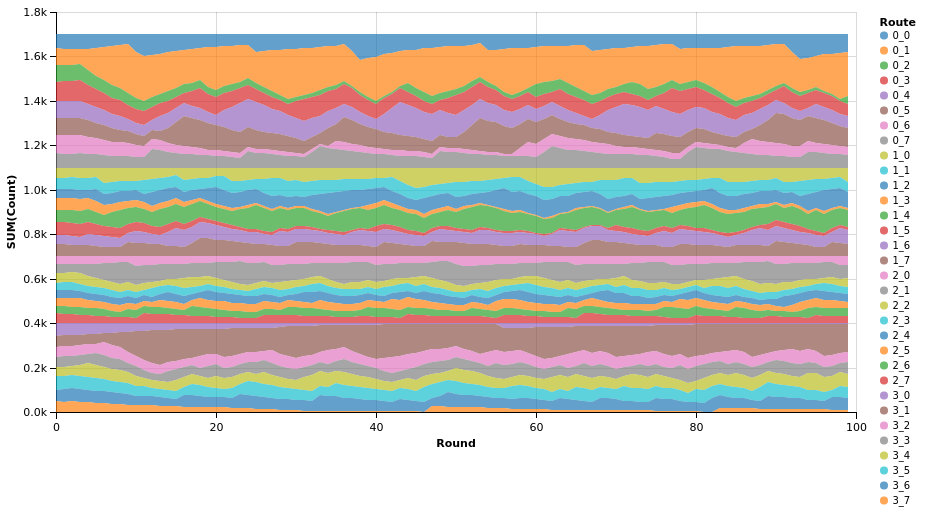

In [9]:
chart = Chart(data).mark_area().encode(x='Round:Q', y='sum(Count):Q', color='Route:N')
chart.configure_cell(height=400, width=800)

### Average Cost over Time

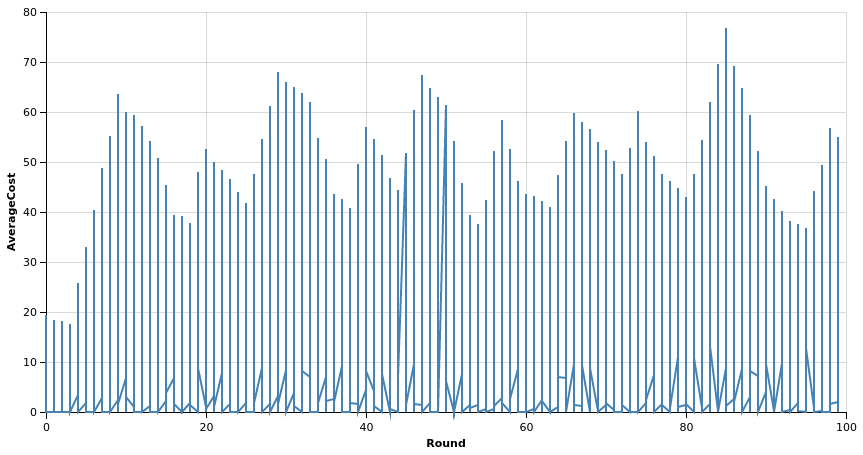

In [10]:
chart = Chart(data).mark_line().encode(x='Round:Q', y='AverageCost:Q')
chart.configure_cell(height=400, width=800)

### Cost per Agent per Route over Time

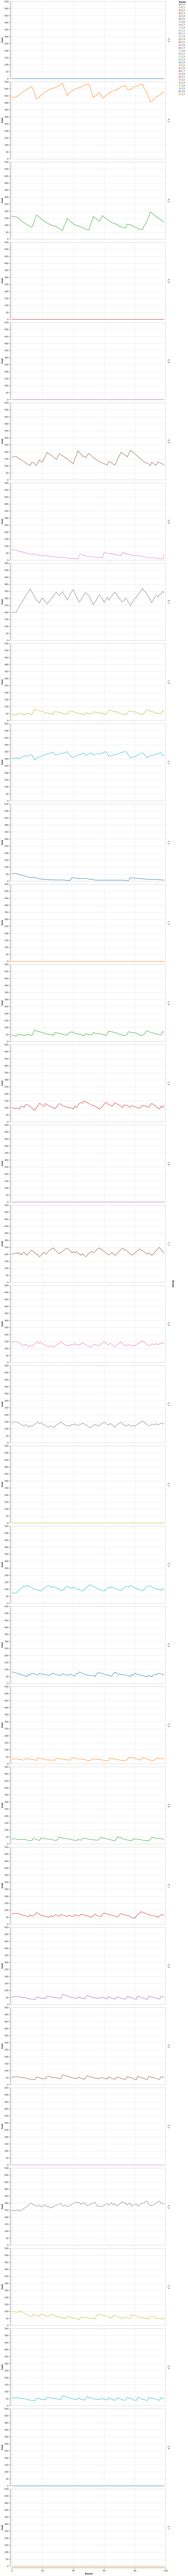

In [11]:
chart = Chart(data).mark_line().encode(x='Round:Q', y='Cost:Q', color='Route:N', row='Route:N')
chart.configure_cell(height=400, width=800)

### Trpf over Time

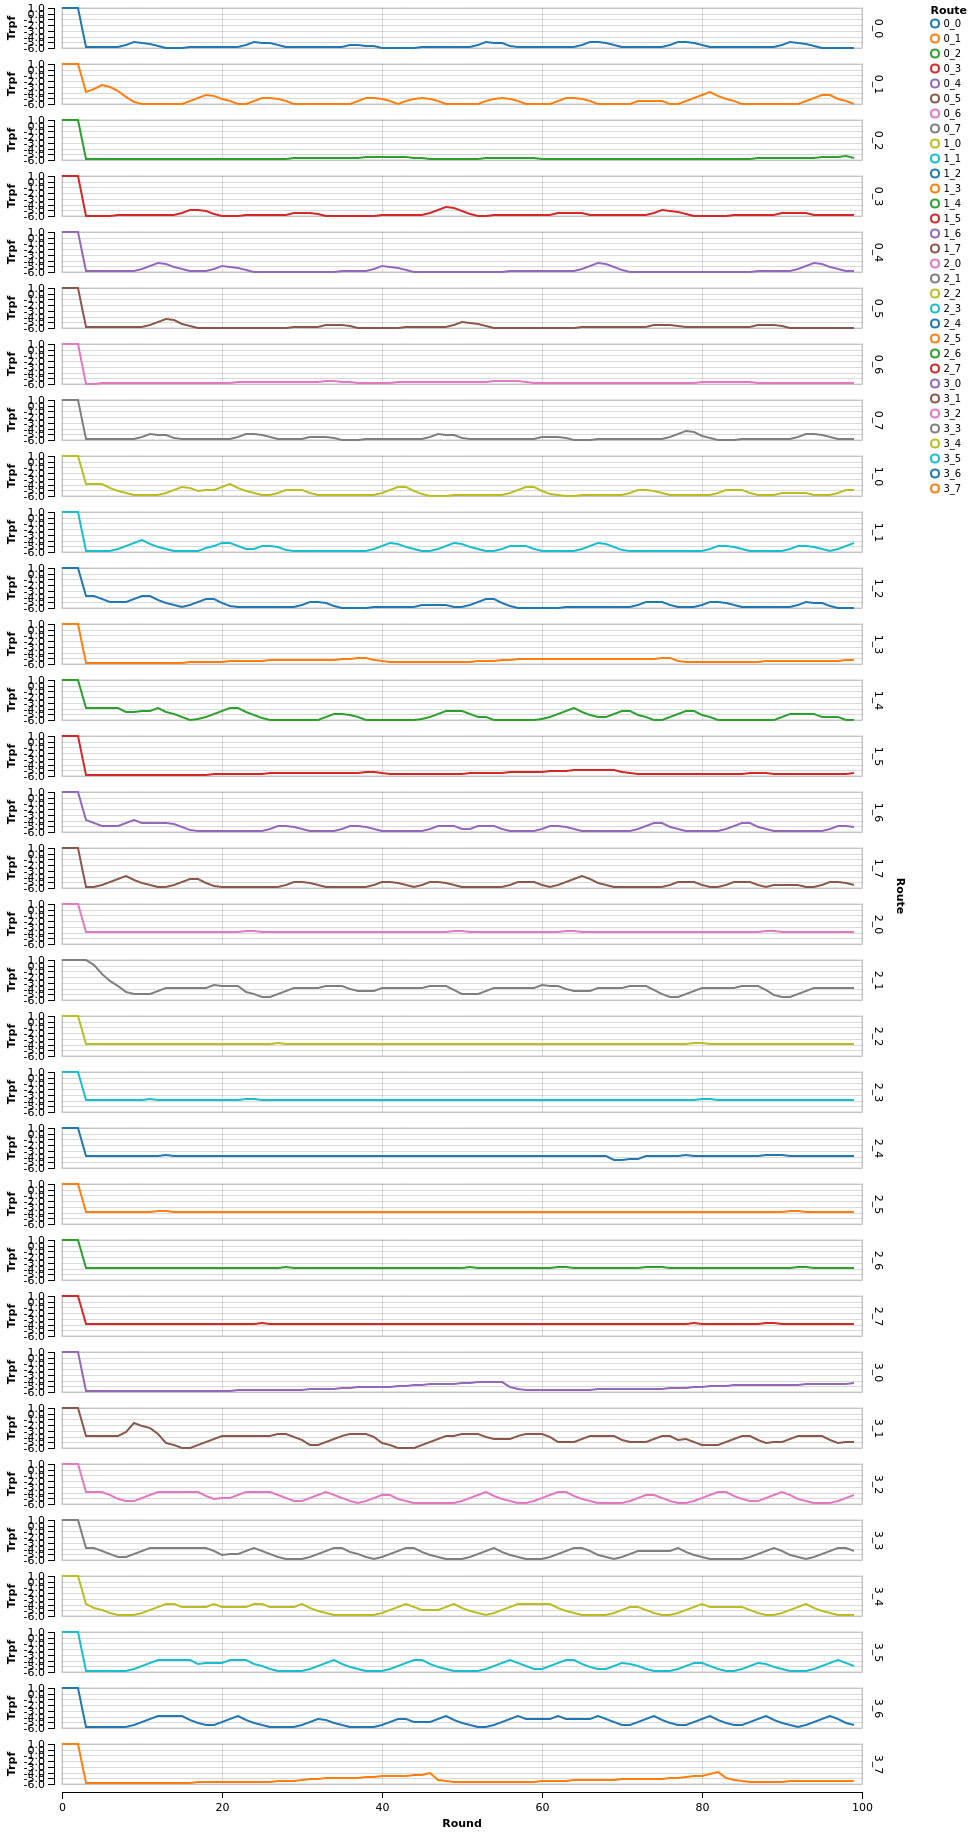

In [12]:
chart = Chart(data).mark_line().encode(x='Round:Q', y='Trpf:Q', color='Route:N', row='Route:N')
chart.configure_cell(height=40, width=800)